# Data Collection

In [1]:
import pandas as pd

In [2]:
from backtesting import Strategy
from backtesting.lib import crossover

C:\Users\antho\Anaconda3\lib\site-packages\backtesting\_plotting.py:44: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
from backtesting import Backtest

In [4]:
%matplotlib inline
import seaborn as sns
from Price_Data import hist_data

In [5]:
import matplotlib.pyplot as plt

In [6]:
btcusd = hist_data('Bitstamp')

C:\Users\antho\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [7]:
btcusd.columns = ['Open']

In [8]:
ss = btcusd.resample('H')

In [9]:
op = ss.first().ffill()
hi = ss.max().ffill()
lo = ss.min().ffill()
cl = ss.last().ffill()

In [10]:
btcusd

,Open
Date,
2011-09-13 13:53:36,5.80
2011-09-13 13:53:44,5.83
2011-09-13 13:53:49,5.90
2011-09-13 13:53:54,6.00
2011-09-13 14:32:53,5.95
...,...
2019-12-12 23:58:18,7184.44
2019-12-12 23:58:20,7184.44
2019-12-12 23:59:05,7190.53


In [11]:
ohlc = op
ohlc.columns = ['Open']
ohlc['High'] = hi
ohlc['Low'] = lo
ohlc['Close'] = cl
ohlc

,Open,High,Low,Close
Date,,,,
2011-09-13 13:00:00,5.80,6.00,5.80,6.00
2011-09-13 14:00:00,5.95,5.95,5.76,5.76
2011-09-13 15:00:00,5.65,5.65,5.65,5.65
2011-09-13 16:00:00,5.65,5.65,5.65,5.65
2011-09-13 17:00:00,5.65,5.65,5.65,5.65
...,...,...,...,...
2019-12-12 19:00:00,7205.66,7218.00,7186.36,7193.66
2019-12-12 20:00:00,7205.14,7250.23,7195.00,7242.49
2019-12-12 21:00:00,7245.85,7253.68,7180.83,7194.57


In [12]:
import datetime as dt

In [13]:
yr1 = ohlc.loc['2018-12-12':]
yr2 = ohlc.loc['2017-12-12':]
yr4 = ohlc.loc['2015-12-12':]

In [21]:
import yfinance as yf

In [22]:
sp_df = yf.download('^GSPC', 
                      start='2011-09-13', 
                      end='2019-12-13', 
                      progress=False,interval='1d')
sp = sp_df.iloc[:,:4]
sp

,Open,High,Low,Close
Date,,,,
2011-09-12,1153.500000,1162.520020,1136.069946,1162.270020
2011-09-13,1162.589966,1176.410034,1157.439941,1172.869995
2011-09-14,1173.319946,1202.380005,1162.729980,1188.680054
2011-09-15,1189.439941,1209.109985,1189.439941,1209.109985
2011-09-16,1209.209961,1220.060059,1204.459961,1216.010010
...,...,...,...,...
2019-12-06,3134.620117,3150.600098,3134.620117,3145.909912
2019-12-09,3141.860107,3148.870117,3135.459961,3135.959961
2019-12-10,3135.360107,3142.120117,3126.090088,3132.520020


In [23]:
sp1 = sp.loc['2018-12-12':]
sp2 = sp.loc['2017-12-12':]
sp4 = sp.loc['2015-12-12':]

# Strategies

In [14]:
def SMA(values,n):
    return pd.Series(values).rolling(n).mean()

In [15]:
class SmaCross(Strategy):
    
    n1 = 37
    n2 = 73
    
    def init(self):
        # Precompute two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()

        # Else, if sma1 crosses below sma2, sell it
        elif crossover(self.sma2, self.sma1):
            self.sell()

In [16]:
def EMA(val,n):
    res = pd.Series(val).copy()
    return res.ewm(span=n,adjust=False).mean()

In [17]:
class EmaCross(Strategy):
    
    n1 = 901
    n2 = 931
    
    def init(self):
        # Precompute two moving averages
        self.ema1 = self.I(EMA, self.data.Close, self.n1)
        self.ema2 = self.I(EMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.ema2, self.ema1):
            self.sell()

In [18]:
def DEMA(val,n):
    exp1 = EMA(val,n)
    exp2 = EMA(exp1,n)
    return 2*exp1 - exp2

In [19]:
class DemaCross(Strategy):
    
    n1 = 681
    n2 = 981
    
    def init(self):
        # Precompute two moving averages
        self.dema1 = self.I(DEMA, self.data.Close, self.n1)
        self.dema2 = self.I(DEMA, self.data.Close, self.n2)
        
    def next(self):
        # If sma1 crosses above ema2, buy the asset
        if crossover(self.dema1, self.dema2):
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.dema2, self.dema1):
            self.sell()

In [20]:
import scipy.interpolate as interp
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Daily returns correlations

In [41]:
btc_sma_1_year = Backtest(yr1,SmaCross,cash=10000).optimize(n1=201,n2=951)._trade_data
sp_sma_1_year = Backtest(sp1,SmaCross,cash=10000).optimize(n1=1,n2=21)._trade_data

In [42]:
btc_equity = btc_sma_1_year['Equity']
sp_equity = sp_sma_1_year['Equity']

In [208]:
btc_equity_interp = btc_equity.asfreq('D').interpolate(method='time')
sp_equity_interp = sp_equity.asfreq('D').interpolate(method='time')

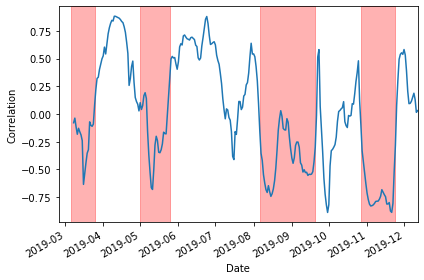

In [236]:
btc_equity_interp.rolling(20).corr(sp_equity_interp).dropna().plot()
plt.ylabel('Correlation')
plt.axvspan(dt.datetime(2019,3,6),dt.datetime(2019,3,25), color='r', alpha=0.3)
plt.axvspan(dt.datetime(2019,5,1),dt.datetime(2019,5,25), color='r', alpha=0.3)
plt.axvspan(dt.datetime(2019,8,6),dt.datetime(2019,9,20), color='r', alpha=0.3)
plt.axvspan(dt.datetime(2019,10,27),dt.datetime(2019,11,24), color='r', alpha=0.3)
plt.tight_layout()
plt.savefig('mtm_corr.png')

In [210]:
btc_dreturn = pd.DataFrame([((btc_equity_interp[i+1]/btc_equity_interp[i])-1) for i in range(len(btc_equity_interp)-1)])
btc_dreturn = btc_dreturn.set_index(btc_equity_interp.index[1:])

In [211]:
sp_dreturn = pd.DataFrame([((sp_equity_interp[i+1]/sp_equity_interp[i])-1) for i in range(len(sp_equity_interp)-1)])
sp_dreturn = sp_dreturn.set_index(sp_equity_interp.index[1:])

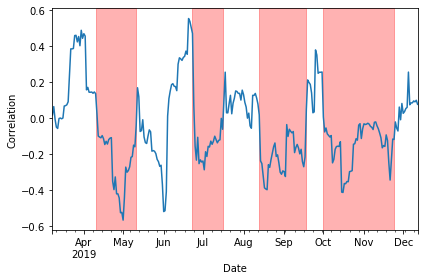

In [237]:
btc_dreturn.rolling(20).corr(sp_dreturn).dropna().plot(legend=None)
plt.ylabel('Correlation')
plt.axvspan(dt.datetime(2019,4,10),dt.datetime(2019,5,11), color='r', alpha=0.3)
plt.axvspan(dt.datetime(2019,6,23),dt.datetime(2019,7,16), color='r', alpha=0.3)
plt.axvspan(dt.datetime(2019,8,13),dt.datetime(2019,9,18), color='r', alpha=0.3)
plt.axvspan(dt.datetime(2019,10,1),dt.datetime(2019,11,24), color='r', alpha=0.3)
plt.tight_layout()
plt.savefig('dreturns_corr.png')

In [392]:
from scipy.stats import norm, chi2
from matplotlib.patches import Ellipse

In [393]:
def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

In [394]:
pts = np.asarray([np.asarray([i[0],j[0]]) for i,j in zip(sp_dreturn.values,btc_dreturn.values)])
mean_pos = pts.mean(axis=0)
cov = np.cov(pts, rowvar=False)

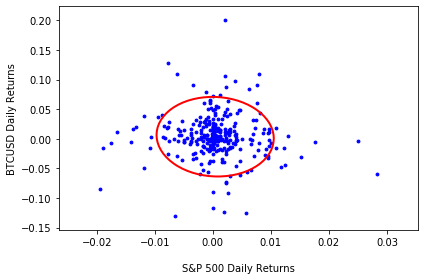

In [396]:
ax = plt.gca()
vals, vecs = eigsorted(cov)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
width, height = 2 * 2 * np.sqrt(vals)
x,y = pts.T
plt.scatter(x,y,c='b',s=8)
ellipse = Ellipse(xy=mean_pos, width=width, height=height, angle=theta,fill=False, lw=2,color='r')
ax.add_artist(ellipse)
plt.xlabel('\nS&P 500 Daily Returns')
plt.ylabel('BTCUSD Daily Returns')
plt.tight_layout()
plt.savefig('scatter.png')

In [403]:
btc_dreturn_list = list(i[0] for i in btc_dreturn.values)
sp_dreturn_list = list(i[0] for i in sp_dreturn.values)

In [404]:
from scipy.stats import pearsonr

In [405]:
stats, p = pearsonr(sp_dreturn_list, btc_dreturn_list)

In [409]:
p

0.40067158218815757

# 1 year walkforwards - S&P 500

In [91]:
sp_y_18_19 = sp.loc['2018-12-12':'2019-12-12']
sp_y_17_18 = sp.loc['2017-12-12':'2018-12-12']
sp_y_16_17 = sp.loc['2016-12-12':'2017-12-12']
sp_y_15_16 = sp.loc['2015-12-12':'2016-12-12']
sp_y_14_15 = sp.loc['2014-12-12':'2015-12-12']
sp_y_13_14 = sp.loc['2013-12-12':'2014-12-12']
sp_y_12_13 = sp.loc['2012-12-12':'2013-12-12']
sp_y_11_12 = sp.loc['2011-12-12':'2012-12-12']

In [94]:
sp_17 = Backtest(sp_y_17_18,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_16 = Backtest(sp_y_16_17,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_15 = Backtest(sp_y_15_16,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_14 = Backtest(sp_y_14_15,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_13 = Backtest(sp_y_13_14,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_12 = Backtest(sp_y_12_13,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_11 = Backtest(sp_y_11_12,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Searching best of 1176 configurations.
  """Entry point for launching an IPython kernel.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Searching best of 1176 configurations.
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Searching best of 1176 configurations.
  after removing the cwd from sys.path.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Searching best of 1176 configurations.
  """


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Searching best of 1176 configurations.
  


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Searching best of 1176 configurations.
  import sys


In [95]:
sp_ema_17 = Backtest(sp_y_17_18,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_ema_16 = Backtest(sp_y_16_17,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_ema_15 = Backtest(sp_y_15_16,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_ema_14 = Backtest(sp_y_14_15,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_ema_13 = Backtest(sp_y_13_14,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_ema_12 = Backtest(sp_y_12_13,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_ema_11 = Backtest(sp_y_11_12,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Searching best of 1176 configurations.
  """Entry point for launching an IPython kernel.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Searching best of 1176 configurations.
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Searching best of 1176 configurations.
  after removing the cwd from sys.path.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Searching best of 1176 configurations.
  """


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Searching best of 1176 configurations.
  


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Searching best of 1176 configurations.
  import sys


In [96]:
sp_dema_17 = Backtest(sp_y_17_18,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_dema_16 = Backtest(sp_y_16_17,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_dema_15 = Backtest(sp_y_15_16,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_dema_14 = Backtest(sp_y_14_15,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_dema_13 = Backtest(sp_y_13_14,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_dema_12 = Backtest(sp_y_12_13,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)
sp_dema_11 = Backtest(sp_y_11_12,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,50),n2=range(1,50),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Searching best of 1176 configurations.
  """Entry point for launching an IPython kernel.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 1176 configurations.
  


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Searching best of 1176 configurations.
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Searching best of 1176 configurations.
  after removing the cwd from sys.path.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Searching best of 1176 configurations.
  """


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Searching best of 1176 configurations.
  


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Searching best of 1176 configurations.
  import sys


In [102]:
sp_training_sma = [sp_11, sp_12, sp_13, sp_14, sp_15, sp_16, sp_17]
sp_test_sma = [sp_y_12_13, sp_y_13_14, sp_y_14_15, sp_y_15_16, sp_y_16_17, sp_y_17_18, sp_y_18_19]
sharpe_sp_sma = []

for (i,j) in zip(sp_training_sma, sp_test_sma):
    sharpe_sp_sma.append(Backtest(j,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=i._strategy.n1, n2=i._strategy.n2)['Sharpe Ratio'])

In [104]:
sp_training_ema = [sp_ema_11, sp_ema_12, sp_ema_13, sp_ema_14, sp_ema_15, sp_ema_16, sp_ema_17]
sp_test_ema = [sp_y_12_13, sp_y_13_14, sp_y_14_15, sp_y_15_16, sp_y_16_17, sp_y_17_18, sp_y_18_19]
sharpe_sp_ema = []

for (i,j) in zip(sp_training_ema, sp_test_ema):
    sharpe_sp_ema.append(Backtest(j,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=i._strategy.n1, n2=i._strategy.n2)['Sharpe Ratio'])

In [106]:
sp_training_dema = [sp_dema_11, sp_dema_12, sp_dema_13, sp_dema_14, sp_dema_15, sp_dema_16, sp_dema_17]
sp_test_dema = [sp_y_12_13, sp_y_13_14, sp_y_14_15, sp_y_15_16, sp_y_16_17, sp_y_17_18, sp_y_18_19]
sharpe_sp_dema = []

for (i,j) in zip(sp_training_dema, sp_test_dema):
    sharpe_sp_dema.append(Backtest(j,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=i._strategy.n1, n2=i._strategy.n2)['Sharpe Ratio'])

In [145]:
sp_bar = pd.DataFrame(np.c_[sharpe_sp_sma,sharpe_sp_ema,sharpe_sp_dema],columns = ['SMA Strategy', 'EMA Strategy', 'DEMA Strategy'])
sp_bar = sp_bar*np.sqrt(12)
sp_bar = sp_bar.set_index(pd.Index(['2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019']))

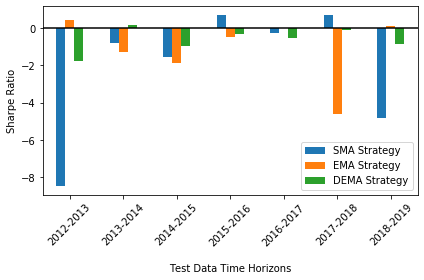

In [146]:
sp_bar.plot(kind='bar',rot=45)
plt.axhline(y=0,c='k')
plt.xlabel('\nTest Data Time Horizons')
plt.ylabel('Sharpe Ratio')
plt.tight_layout()
plt.savefig('sp_walkthrough.png')

In [157]:
sp_optimal_sma = [i['Sharpe Ratio']*np.sqrt(12) for i in sp_training_sma]
sp_optimal_sma.append(1.9885)
sp_optimal_ema = [i['Sharpe Ratio']*np.sqrt(12) for i in sp_training_ema]
sp_optimal_ema.append(2.3487)
sp_optimal_dema = [i['Sharpe Ratio']*np.sqrt(12) for i in sp_training_dema]
sp_optimal_dema.append(2.3764)

In [159]:
sp_optimal_bar = pd.DataFrame(np.c_[sp_optimal_sma, sp_optimal_ema, sp_optimal_dema], columns = ['SMA Strategy', 'EMA Strategy', 'DEMA Strategy'])
sp_optimal_bar

,SMA Strategy,EMA Strategy,DEMA Strategy
0,32.073370,3.135747,9.226010
1,1.323039,0.805432,0.430518
2,1.303131,0.820055,0.913182
3,4.398958,0.137264,0.315505
4,3.164793,0.889247,1.976538
5,2.078036,1.522847,0.688394
6,124.880839,1.143869,1.534230
7,1.988500,2.348700,2.376400


# 1 year walkforwards - BTCUSD

In [130]:
y_18_19 = ohlc.loc['2018-12-12':'2019-12-12']
y_17_18 = ohlc.loc['2017-12-12':'2018-12-12']
y_16_17 = ohlc.loc['2016-12-12':'2017-12-12']
y_15_16 = ohlc.loc['2015-12-12':'2016-12-12']
y_14_15 = ohlc.loc['2014-12-12':'2015-12-12']
y_13_14 = ohlc.loc['2013-12-12':'2014-12-12']
y_12_13 = ohlc.loc['2012-12-12':'2013-12-12']
y_11_12 = ohlc.loc['2011-12-12':'2012-12-12']

In [131]:
btc_17 = Backtest(y_17_18,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_16 = Backtest(y_16_17,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_15 = Backtest(y_15_16,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_14 = Backtest(y_14_15,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_13 = Backtest(y_13_14,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_12 = Backtest(y_12_13,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_11 = Backtest(y_11_12,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Searching best of 4950 configurations.
  """Entry point for launching an IPython kernel.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Searching best of 4950 configurations.
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Searching best of 4950 configurations.
  after removing the cwd from sys.path.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Searching best of 4950 configurations.
  """


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Searching best of 4950 configurations.
  


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Searching best of 4950 configurations.
  import sys


In [132]:
btc_ema_17 = Backtest(y_17_18,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_ema_16 = Backtest(y_16_17,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_ema_15 = Backtest(y_15_16,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_ema_14 = Backtest(y_14_15,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_ema_13 = Backtest(y_13_14,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_ema_12 = Backtest(y_12_13,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_ema_11 = Backtest(y_11_12,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Searching best of 4950 configurations.
  """Entry point for launching an IPython kernel.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Searching best of 4950 configurations.
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Searching best of 4950 configurations.
  after removing the cwd from sys.path.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Searching best of 4950 configurations.
  """


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Searching best of 4950 configurations.
  


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Searching best of 4950 configurations.
  import sys


In [133]:
btc_dema_17 = Backtest(y_17_18,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_dema_16 = Backtest(y_16_17,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_dema_15 = Backtest(y_15_16,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_dema_14 = Backtest(y_14_15,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_dema_13 = Backtest(y_13_14,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_dema_12 = Backtest(y_12_13,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)
btc_dema_11 = Backtest(y_11_12,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=range(1,1000,10),n2=range(1,1000,10),constraint=lambda p: p.n1<p.n2)

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Searching best of 4950 configurations.
  """Entry point for launching an IPython kernel.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Searching best of 4950 configurations.
  


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Searching best of 4950 configurations.
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Searching best of 4950 configurations.
  after removing the cwd from sys.path.


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Searching best of 4950 configurations.
  """


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Searching best of 4950 configurations.
  


C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Searching best of 4950 configurations.
  import sys


In [134]:
btc_training_sma = [btc_11, btc_12, btc_13, btc_14, btc_15, btc_16, btc_17]
btc_test_sma = [y_12_13, y_13_14, y_14_15, y_15_16, y_16_17, y_17_18, y_18_19]
sharpe_btc_sma = []

for (i,j) in zip(btc_training_sma, btc_test_sma):
    sharpe_btc_sma.append(Backtest(j,SmaCross,cash=10000).optimize('Sharpe Ratio',n1=i._strategy.n1, n2=i._strategy.n2)['Sharpe Ratio'])

In [139]:
btc_training_ema = [btc_ema_11, btc_ema_12, btc_ema_13, btc_ema_14, btc_ema_15, btc_ema_16, btc_ema_17]
btc_test_ema = [y_12_13, y_13_14, y_14_15, y_15_16, y_16_17, y_17_18, y_18_19]
sharpe_btc_ema = []

for (i,j) in zip(btc_training_ema, btc_test_ema):
    sharpe_btc_ema.append(Backtest(j,EmaCross,cash=10000).optimize('Sharpe Ratio',n1=i._strategy.n1, n2=i._strategy.n2)['Sharpe Ratio'])

In [141]:
btc_training_dema = [btc_dema_11, btc_dema_12, btc_dema_13, btc_dema_14, btc_dema_15, btc_dema_16, btc_dema_17]
btc_test_dema = [y_12_13, y_13_14, y_14_15, y_15_16, y_16_17, y_17_18, y_18_19]
sharpe_btc_dema = []

for (i,j) in zip(btc_training_dema, btc_test_dema):
    sharpe_btc_dema.append(Backtest(j,DemaCross,cash=10000).optimize('Sharpe Ratio',n1=i._strategy.n1, n2=i._strategy.n2)['Sharpe Ratio'])

In [147]:
btc_bar = pd.DataFrame(np.c_[sharpe_btc_sma, sharpe_btc_ema, sharpe_btc_dema], columns = ['SMA Strategy', 'EMA Strategy', 'DEMA Strategy'])
btc_bar = btc_bar*np.sqrt(12)
btc_bar = btc_bar.set_index(pd.Index(['2012-2013', '2013-2014', '2014-2015', '2015-2016', '2016-2017', '2017-2018', '2018-2019']))

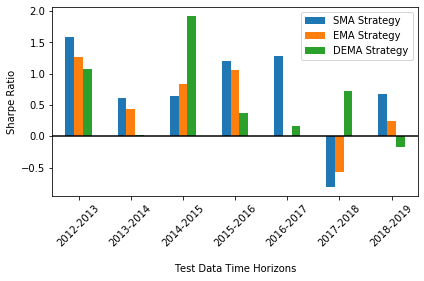

In [150]:
btc_bar.plot(kind='bar', rot=45)
plt.axhline(y=0,c='k')
plt.xlabel('\nTest Data Time Horizons')
plt.ylabel('Sharpe Ratio')
plt.tight_layout()
plt.savefig('walkforward_test.png')

In [153]:
btc_short_sma = [i._strategy.n1 for i in btc_training_sma]
btc_short_sma.append(201)
btc_long_sma = [i._strategy.n2 for i in btc_training_sma]
btc_long_sma.append(951)